In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 9, 6
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC

# Generate Imbalanced Datasets

In [0]:
# make 3-class dataset for classification
center1 = [[0, 0]]
X1, y1 = make_blobs(n_samples=800, centers=center1, random_state=42)
center2 = [[0, 0],[1, 1]]
X2, y2 = make_blobs(n_samples=200, centers=center2, random_state=42, cluster_std=0.3)
X = np.vstack((X1, X2))
y = np.hstack((y1, y2))

在圖上紅色點表示為壞人(1)，藍色點是好人(0)，今天身為一位警察該如何透過兩個feature從好人中去抓出壞人呢？
這邊產生的資料只有10%是壞人 90%是好人

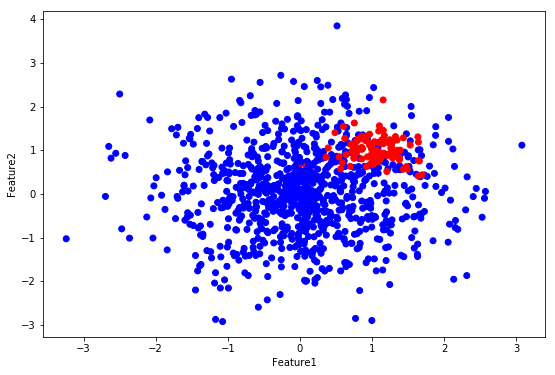

In [0]:
color = "br"
color = [color[y[i]] for i in range(len(y))]
plt.scatter(X[:,0],X[:,1],c=color)
plt.xlabel('Feature1')
plt.ylabel('Feature2')

# Predict with Logistic Regression
準確率比全猜好人還低？？？？？XD 

Accuracy:0.88


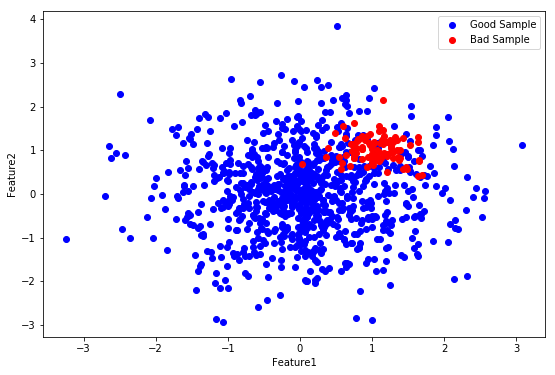

In [0]:
model = LogisticRegression()
model.fit(X, y)
prediction = model.predict(X)
print('Accuracy:%.2f'%model.score(X, y))
color = "br"
label = ['Good Sample', 'Bad Sample']
#color = [color[prediction[i]] for i in range(len(y))]
#label = [label[prediction[i]] for i in range(len(y))]
for i in range(2):
    plt.scatter(X[y==i][:,0],X[y==i][:,1],c=color[i], label=label[i])
plt.legend()    
plt.xlabel('Feature1')
plt.ylabel('Feature2')

# 利用預測機率代替預測結果
在分類問題中，不管logistic regression還是svm在求解maxmum likelyhood，因此最後算出來的邊界都是一個軟性邊界（機率分佈）。例如在上例中logistic regression預測出來model.predict_proba(X)如下，第一欄代表被預測為0（好人）的機率，第二欄代表被預測為1（壞人）的機率。在一般model.predict給出的預測測值是直接比較第一欄和第二欄的大小決定的。例如在這裏第一筆資料被預測為0（好人）的機率為0.9812，被預測為0.01879，因此模型就會預測這筆資料為0。但是在imbalanced data的情況下，我們會去調整threshold以達到目的。假設我們在這個case中想要抓出大部分的壞人，那也許我們的決策也許是要設定被預測為1的機率只要大於20%那我們就認定他是壞人，如此的話就可以抓出大部分的壞人，那20%就是我們所設定的threshold。之前有提到一般以F1_score來權衡precision和recall，因此在這樣的case下我們會去調整threshold來求得最大的F1_score。

In [0]:
print(model.predict_proba(X))

[[ 0.93888571  0.06111429]
 [ 0.42284021  0.57715979]
 [ 0.91550431  0.08449569]
 ..., 
 [ 0.59365023  0.40634977]
 [ 0.64880506  0.35119494]
 [ 0.98317867  0.01682133]]


# 定義function比較各個不同threshold所形成的分類圖。
這邊主要是要將分類問圖形化給大家看，如果看不懂的話只要知道fucntion的輸入為
1. model_type: 可選擇Logistic 或 SVC
2. plot_dict: key值為設定的threshold，value代表的是subplot的index

In [0]:
def auc(model_type, plot_dict):
    model_dict = {'Logistic':LogisticRegression(),
                 'SVC':SVC(kernel='rbf', probability= True),}

    model = model_dict[model_type]
    model.fit(X, y)
    tpr_temp=[]
    fpr_temp=[]
    precision_temp=[]
    recall_temp=[]
    f1_score_temp=[]
    for  threshold in plot_dict:
        pred = (model.predict_proba(X)[:,1] >= threshold).astype(int) #將預測機率大於threshold的分類為1
        #先算出confusion matrix在算出其他評估值
        cm = confusion_matrix(y, pred)
        tpr = cm[1][1]/cm.sum(axis=1)[1]
        fpr = cm[1][0]/cm.sum(axis=0)[0] #2018/7/2 需確認 axis=1 是否才正確?
        pre = cm[1][1]/cm.sum(axis=0)[1] #precision
        re = cm[1][1]/cm.sum(axis=1)[1] #recall
        f1 = 2*(pre*re)/(pre+re)
        #畫圖
        color = "br"
        color = [color[pred[j]] for j in range(len(pred))]
        plt.subplot(plot_dict[threshold])
        plt.tight_layout()
        plt.scatter(X[:,0],X[:,1],c=color)
        plt.title('threshold:%.1f'%threshold+'\n'+'accuracy:%.2f'%accuracy_score(y, pred)
                  +'\n'+'precision:%.2f'%pre+'\n'+'recall:%.2f'%re)
        
        
        #將各種評估值存取成list
        tpr_temp.append(tpr)
        fpr_temp.append(fpr)
        precision_temp.append(pre)
        recall_temp.append(re)
        f1_score_temp.append('nan' if f1!=f1 else round(f1,3))
    
    return f1_score_temp, tpr_temp, fpr_temp, precision_temp, recall_temp

# Logistic Regression with varied threshold

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


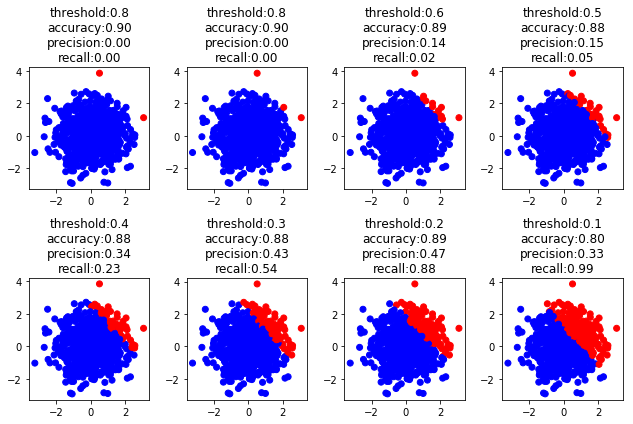

In [0]:
#利用dict的key值input threshold, value值input為subplot的index，例如在這裏要畫出八張圖
#247個數字代表的意思為：
# 24 -> 形成2x4個subplot; 7 -> 圖上從左上角開始往右邊數的index
plot_dict = {0.85:241,0.8:242,0.6:243,0.5:244,0.4:245,0.3:246,0.2:247,0.1:248} 
# 自訂的function會回傳不同threshold的f1_score, tpr, fpr, precision和 recall
f1_0, tpr0, fpr0, precision0, recall0 = auc('Logistic', plot_dict )

#  Precision & Recall & F1_Score
圖形化 Precsion Recall curve，並在個點旁邊標出對應的f1_score 

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


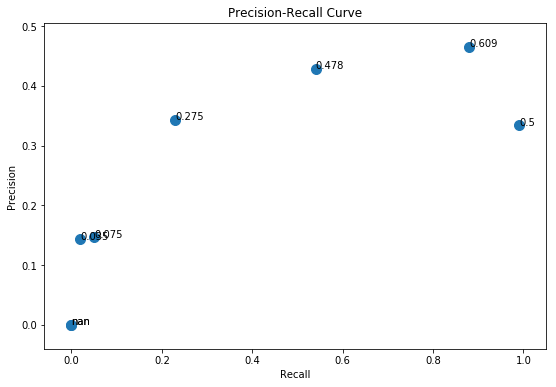

In [0]:
plt.scatter(recall0 ,precision0, s=100)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
# Show F1 Score on each point
for i, txt in enumerate(f1_0):
    plt.annotate(txt, (recall0[i],precision0[i])) 


plt.show()

# SVM with Varied threshold

/Users/Jacklin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


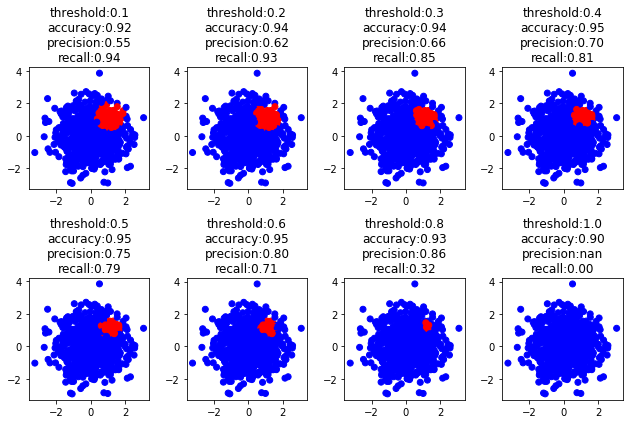

In [0]:
plot_dict = {0.1:241,0.2:242,0.3:243,0.4:244,0.5:245,0.6:246,0.8:247,1:248}
f1_1, tpr1, fpr1, precision1, recall1 = auc('SVC', plot_dict )

# Compare Performance between Logistic Regression & SVM
比較logistic regression和SVM的auc，大家應該可以清楚地看出來哪個模型在這個問題中表現比較好。

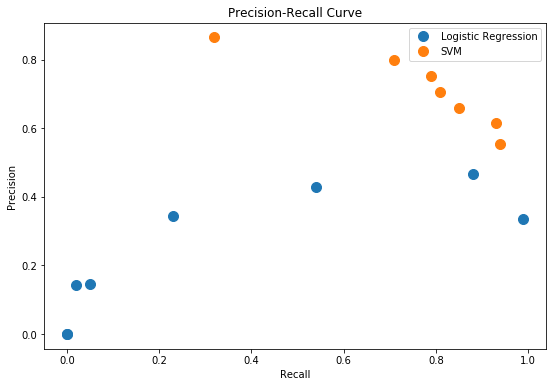

In [0]:
plt.plot(recall0, precision0, '.', label = 'Logistic Regression', markersize=20)
plt.plot(recall1, precision1, '.', label = 'SVM', markersize=20)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall Curve')
plt.show()

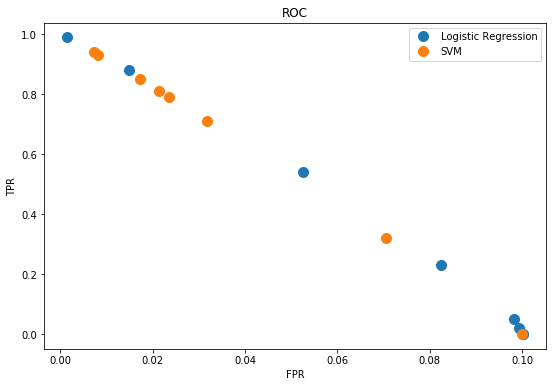

In [0]:
plt.plot(fpr0, tpr0, '.', label = 'Logistic Regression', markersize=20)
plt.plot(fpr1, tpr1, '.', label = 'SVM', markersize=20)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()